# DA 225o
## Tutorial on Transformer Encoders




# Learning Objectives

At the end of the experiment, you will be able to:

* Understand the big picture of transformers
* Understand & implement positional embedding
* Understand & implement multi-head attention
* Understand & build transformer block by assembling individual components viz. positional encoding, multi-head attention, skip connection, layer normalzation
* Understand & build custom encoder transformer architecture
* Perform classification with custom build encoder transformer architecture using Huggingface built in dataset and tokenizer


# Installing packages

In [1]:
!pip install transformers datasets

# Importing Required Libraries:

In [2]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import dataset
import numpy as np
import matplotlib.pyplot as plt

from transformers import AutoTokenizer, DataCollatorWithPadding
from datasets import load_dataset
from torch.utils.data import DataLoader
from datetime import datetime
from pprint import pprint

import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import pandas as pd

from wordcloud import WordCloud

/home/mothi/anaconda3/envs/afno/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Example : Alex took the book from the bag and opened it.

# **Encoder Transformer**

Figure below shows the **Transformer Model Architecture** as per the paper ["**Attention Is All You Need**"](https://arxiv.org/pdf/1706.03762v6.pdf) .Here, we are going to implement **Encoder Transformer** and try to understand how it function. We are writing **'as per the paper'** to  mention this paper throughout this notebook.

To completely understand the Encoder Transformer, it is imperative to understand Self Attention  ( [Details of Self-Attention](https://colab.research.google.com/drive/1fvoLK4zk1C_yA1aRYg1K1LQJ2ivAJQMk?usp=sharing)) which is used inside Multi-head Attention. The data after passing the TextVectorization layer and Embedding layer will pass the Self Attention layer.


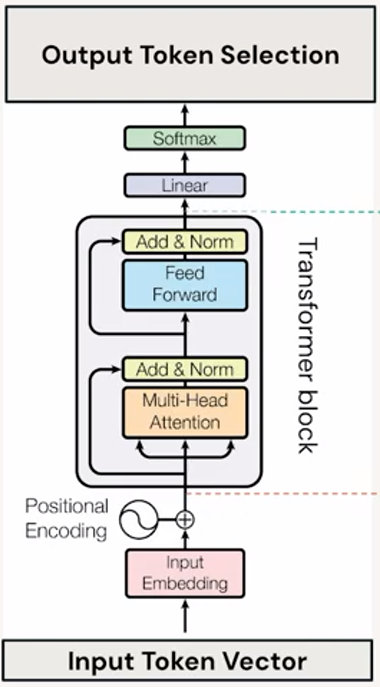

# **1. Designing Encoder**

## Defining Multi Head Attention

**Multihead Attention**

In the Transformer, the Attention module repeats its computations multiple times in parallel. Each of these is called an Attention Head. The Attention module splits its Query, Key, and Value parameters N-ways and passes each split independently through a separate Head. All of these similar Attention calculations are then combined together to produce a final Attention score. This is called Multi-head attention and gives the Transformer greater power to encode multiple relationships and nuances for each word.



In the paper, the diagram for a scaled dot product attention does not use any weights at all. Instead, the weights are included only in the multi head attention block, shown in figure below :

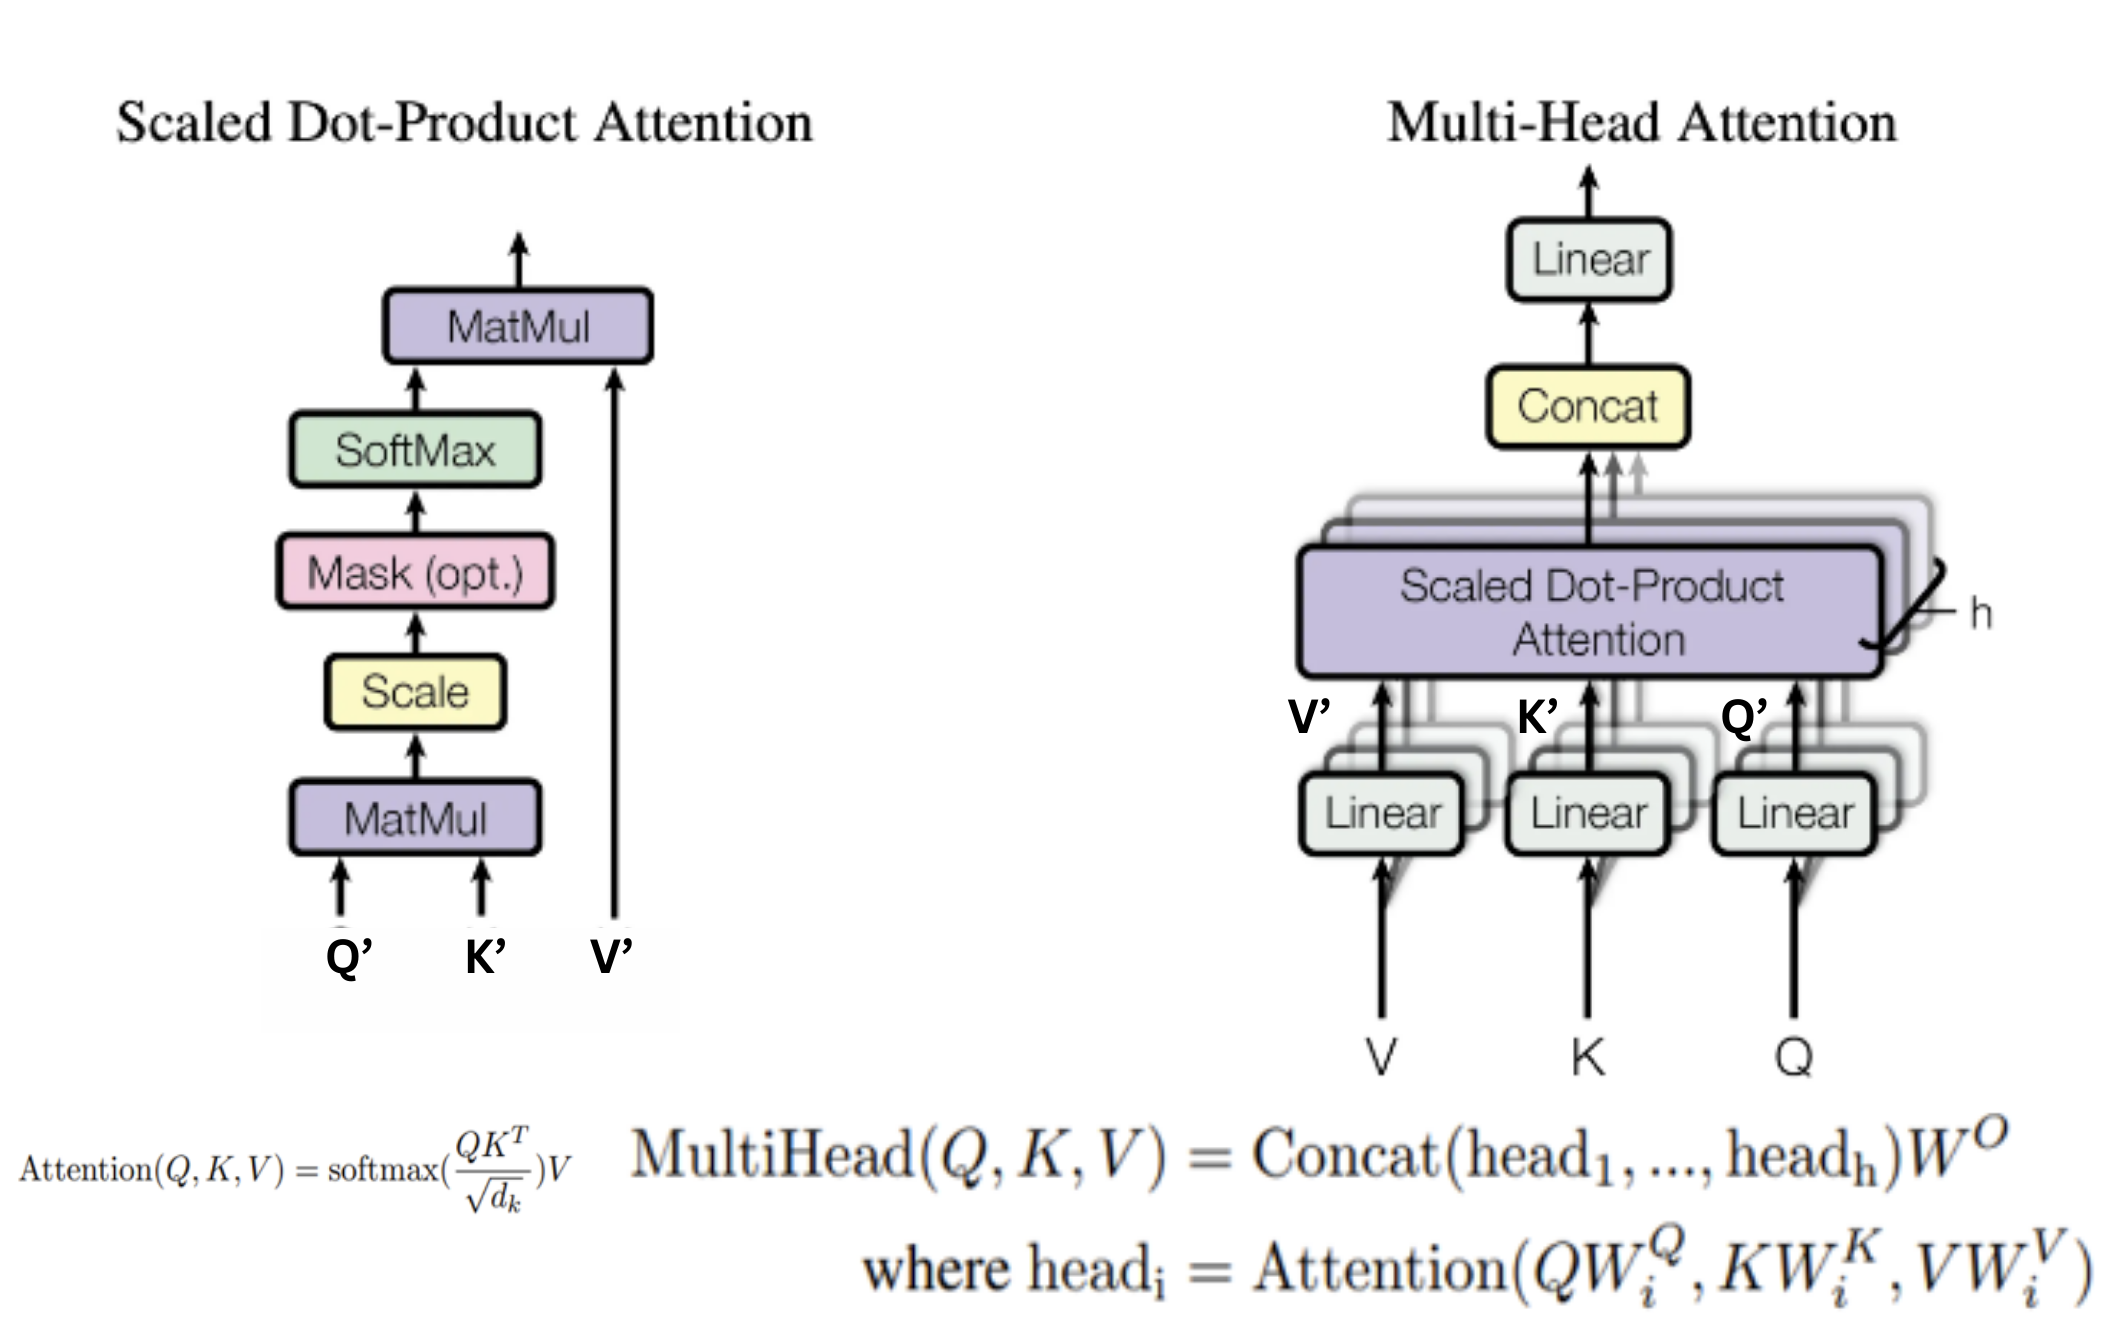

**Attention Calculation & Shape**
<center>
<img src= "https://cdn.extras.talentsprint.com/aiml/Experiment_related_data/Images/Multi_head_attention_shape_tracking.png" width=800px/>
</center>

**Final Projection :** $ Output = concat(A_1, A_2, ..., A_h)  W^{o} $

**Shape of :**  $ concat (A_1, A_2, ..., A_h) \Rightarrow  (T \times hd_v) $

**Shape of:**  $  W^{o} \Rightarrow (hd_v \times d_{model}) $

**Shape of final:**  $ Ouput = concat (A_1, A_2, ..., A_h) W^{o} \Rightarrow  (T \times hd_v) \times (hd_v \times d_{model})  \Rightarrow  (T \times d_{model}) \Leftarrow $ **Back to the initial input shape.**

Note : Batch size is not displayed here.

In [3]:
class MultiHeadAttention(nn.Module):
  def __init__(self, d_k, d_model, n_heads):
    super().__init__()

    # Assume d_v =d_k
    self.d_k=d_k
    self.n_heads = n_heads

    self.key = nn.Linear (d_model, d_k*n_heads)
    self.query = nn.Linear (d_model, d_k*n_heads)
    self.value = nn.Linear (d_model, d_k*n_heads)

    # final linear layer
    self.fc=nn.Linear (d_k*n_heads, d_model)

  def forward(self, q,k,v, mask=None):
    
    q=self.query(q) # N x T x (hd_k)
    k=self.key(k) # N x T x (hd_k)
    v=self.value(v) # N x T x (hd_k)

    N=q.shape[0]
    T=q.shape[1]

    # change the shape to:
    # (N, T, h, d_k) --> N, h, T, d_k)
    # in order for matrix multiply to work properly
    q=q.view(N, T, self.n_heads, self.d_k).transpose(1,2)
    k=k.view(N, T, self.n_heads, self.d_k).transpose(1,2)
    v=v.view(N, T, self.n_heads, self.d_k).transpose(1,2)

    # Compute attention weights
    # (N, h, T, d_k)   x  (N, h, d_k, T )  --> (N, h, T, T)
    attn_scores = q@k.transpose(-2,-1)/math.sqrt(self.d_k) # Scaled dot product;  @ --> torch.matmul
    if mask is not None:
      attn_scores = attn_scores.masked_fill(mask[:,None,None,:]==0, float('-inf'))
    attn_weights = F.softmax(attn_scores, dim =-1)

    # Compute attention-weighted values
    # (N, h, T, T) x (N, h, T, d_k) --> (N, h, T, d_k)
    A = attn_weights @ v

    # reshape it back before final linear layer
    A = A.transpose(1,2)  # (N, T, h, d_k)
    A = A.contiguous().view(N, T, self.d_k*self.n_heads) # (N, T, h*d_k)

    # projection
    return self.fc(A) # (N, T, h*d_k) -> (N, T, d_model)

## **Designing Transformer Block**

The Transformer Encoder consists of a stack of
 identical layers (Encoder Block) as shown in figure below, where each layer further consists of two main sub-layers:

* The first sub-layer comprises a multi-head attention mechanism that receives the queries, keys, and values as inputs.
* A second sub-layer comprises a fully-connected feed-forward network.

Following each of these two sub-layers is layer normalization, into which the sub-layer input (through a residual/skip connection) and output are fed.

Regularization is also introduced into the model by applying a dropout to the output of each sub-layer (before the layer normalization step), as well as to the positional encodings before these are fed into the encoder.



<br>
<center>
<img src="https://cdn.extras.talentsprint.com/aiml/Experiment_related_data//Images/Encoder_tfr_block_unfolded.png"  width=600 px />$⇒$
<img src="https://cdn.extras.talentsprint.com/aiml/Experiment_related_data/Images/Encoder_tfr_block.png" width=180 px/>

</center>

The transformer encoder architecture typically consists of multiple layers, each of which includes a self-attention mechanism and a feed-forward neural network. The self-attention mechanism allows the model to weigh the importance of different input sequence parts by calculating the embeddings' dot product. This mechanism is also known as multi-head attention.

The feed-forward network allows the model to extract higher-level features from the input. This network usually comprises two linear layers with a ReLU activation function in between. The feed-forward network allows the model to extract deeper meaning from the input data and more compactly and usefully represent the input.In the paper, an ANN with one hidden layer and a ReLu activation in the middle  with no activation function at output layer has been implemented.

The transformer encoder is a crucial part of the transformer encoder-decoder architecture, which is widely used for natural language processing tasks.

In [4]:
class TransformerBlock(nn.Module):
  def __init__(self, d_k, d_model, n_heads, dropout_prob = 0.1):
    super().__init__()

    self.ln1 = nn.LayerNorm(d_model)
    self.ln2 = nn.LayerNorm(d_model)
    self.mha = MultiHeadAttention(d_k, d_model, n_heads)

    self.ann = nn.Sequential(
        nn.Linear (d_model, d_model*4),
        nn.GELU(),
        nn.Linear(d_model*4, d_model),
        nn.Dropout(dropout_prob),
    )

    self.dropout = nn. Dropout(p=dropout_prob)

  def forward (self, x, mask=None):
    x = self.ln1(x + self.mha(x, x, x, mask))
    x = self.ln2(x + self.ann(x))
    x = self.dropout(x)
    return x

## **Designing Positional Embedding**

**Positional Embedding = Word Embedding + Positional Encoding**

**Positional Encoding**

Passing embeddings directly into the transformer block results in missing of information about the order of tokens. As attention is permutation invariant i.e. order of token does not matter to attention.
Although transformers are a sequence model, it appears that this important detail has somehow been lost. Positional encoding is for rescue.

Positional encoding add positional information to the existing embeddings.

**A unique set of numbers added at each position of the existing embeddings**, such that this new set of numbers can uniquely identify which postion they are located at. Following two ways are there to add positional encoding:


1. Positional Encoding by SubClassing the Embedding Layer (Trainable)
2. Positional Encoding scheme as per the paper (Non-Trainable)

 In this scheme the encoding is created by using a set of sins and cosines at different frequencies. The  paper uses the following formula for calculating the positional encoding. [Positional Encoding Vizualization.](https://erdem.pl/2021/05/understanding-positional-encoding-in-transformers)

$$\ {PE_{(pos, 2i)} = \sin(pos / 10000^{2i / d_{model}})} $$
$$\ {PE_{(pos, 2i+1)} = \cos(pos / 10000^{2i / d_{model}})} $$

We are going to implement Positional Encoding as per the paper.

In [5]:
class PositionalEncoding(nn.Module):
  def __init__(self, d_model, max_len =2048, dropout_porb=0.1):
    super().__init__()
    self.dropout = nn.Dropout(p = dropout_porb)

    position = torch.arange(max_len).unsqueeze(1)
    exp_term = torch.arange(0, d_model, 2)
    div_term = torch.exp(exp_term*(-math.log(10000.0)/d_model))
    pe = torch.zeros(1, max_len, d_model)
    pe[0, :, 0::2] = torch.sin(position *div_term)
    pe[0, :, 1::2] = torch.cos(position *div_term)
    self.register_buffer('pe', pe)


  def forward(self, x):
    # x.shape : N x T x D
    x=x + self.pe[:, :x.size(1), :]
    return self.dropout(x)


## **Creating Encoder Class**
Stacking Attenttion blocks gives a Transfomer! Shown in figure below:

<br>
<center>
<img src= "https://cdn.extras.talentsprint.com/aiml/Experiment_related_data/Images/Encoder_transfomer.png" width=1000px/>
</center>

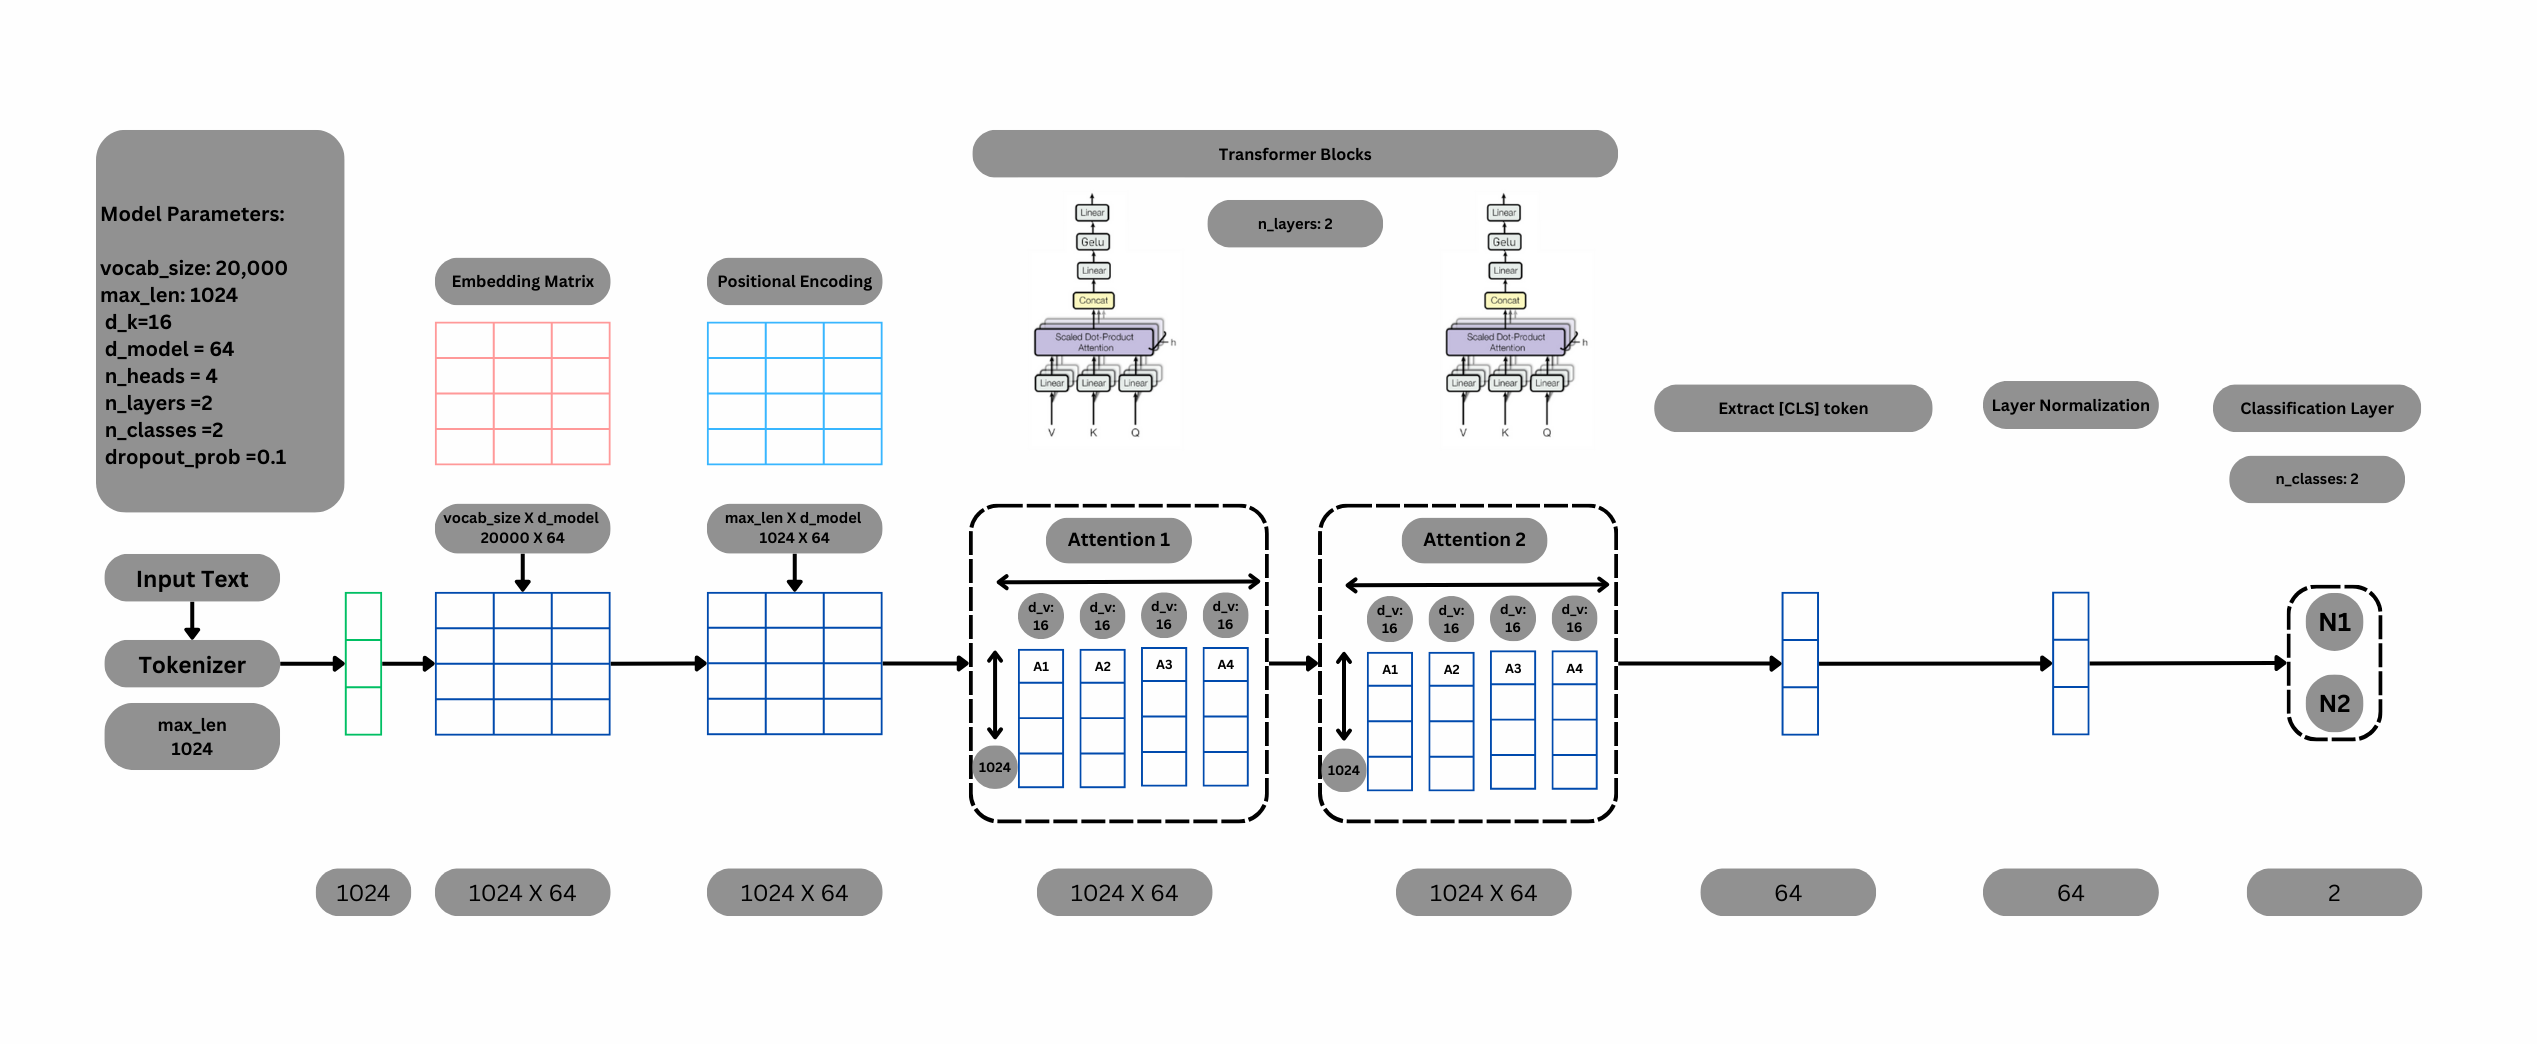

In [6]:
class Encoder(nn.Module):
  def __init__(self, vocab_size, max_len, d_k, d_model, n_heads, n_layers, n_classes, dropout_prob):
    super().__init__()

    self.embedding=nn.Embedding(vocab_size, d_model)
    self.pos_encoding=PositionalEncoding(d_model, max_len, dropout_prob)
    transformer_blocks=[TransformerBlock(d_k, d_model, n_heads, dropout_prob) for _ in range(n_layers) ]
    self.transformer_blocks = nn.Sequential(*transformer_blocks)
    self.ln = nn.LayerNorm(d_model)
    self.fc = nn.Linear(d_model, n_classes)

  def forward(self, x, mask = None):
    x=self.embedding(x)
    x=self.pos_encoding(x)
    for block in self.transformer_blocks:
      x = block( x, mask)

    # many to one (x has the shape N x T x D)
    # Use the output of the first token (CLS token) for classification
    cls_token_output = x[:, 0, :] # Assuming the [CLS] token is the first token
    cls_token_output = self.ln(cls_token_output)
    logits = self.fc(cls_token_output)
    return cls_token_output,logits

## **Testing the forward pass with dummy values**

In [7]:

vocab_size =20000
max_len = 1024
d_k=16
d_model = 64
n_heads=4
n_layers =2
n_classes =5
dropout_prob=0.1
model = Encoder(vocab_size, max_len, d_k, d_model, n_heads, n_layers, n_classes, dropout_prob)


In [8]:
device = torch.device ("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
model.to(device)

cuda:0


Encoder(
  (embedding): Embedding(20000, 64)
  (pos_encoding): PositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer_blocks): Sequential(
    (0): TransformerBlock(
      (ln1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (ln2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (mha): MultiHeadAttention(
        (key): Linear(in_features=64, out_features=64, bias=True)
        (query): Linear(in_features=64, out_features=64, bias=True)
        (value): Linear(in_features=64, out_features=64, bias=True)
        (fc): Linear(in_features=64, out_features=64, bias=True)
      )
      (ann): Sequential(
        (0): Linear(in_features=64, out_features=256, bias=True)
        (1): GELU(approximate='none')
        (2): Linear(in_features=256, out_features=64, bias=True)
        (3): Dropout(p=0.1, inplace=False)
      )
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (ln1): LayerNorm((64,), eps=1e-05, 

In [9]:
x = np.random.randint(0, vocab_size, size = (8,512))
x_t = torch.tensor(x).to(device)
print(x_t.shape)

torch.Size([8, 512])


In [10]:
mask = np.ones((8,512))
mask[:, 256:] = 0
mask_t = torch.tensor (mask).to (device)

In [11]:
cls_token_output,y = model(x_t, mask_t)

In [12]:
cls_token_output.shape

torch.Size([8, 64])

In [13]:
y.shape

torch.Size([8, 5])

# **2. Train the Encoder**

We are going to use model built above (custom  encoder architecture) for sentiment classificaiton. Huggingface Library is used for demonstration using built in dataset **`glue - sst2`** and tokenizer.

## Load the Data

In [14]:
raw_datasets = load_dataset("glue", "sst2") # sst2 is DataSet for sentiment analysis as a part of glue bench-mark

## Understand the Data

In [15]:
raw_datasets

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label', 'idx'],
        num_rows: 67349
    })
    validation: Dataset({
        features: ['sentence', 'label', 'idx'],
        num_rows: 872
    })
    test: Dataset({
        features: ['sentence', 'label', 'idx'],
        num_rows: 1821
    })
})

In [16]:
raw_datasets['train'].features

{'sentence': Value(dtype='string', id=None),
 'label': ClassLabel(names=['negative', 'positive'], id=None),
 'idx': Value(dtype='int32', id=None)}

In [17]:
raw_datasets['train']

Dataset({
    features: ['sentence', 'label', 'idx'],
    num_rows: 67349
})

In [18]:
# common properties and functions available for interacting with the dataset
dir(raw_datasets['train'])

['_TF_DATASET_REFS',
 '__class__',
 '__del__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__enter__',
 '__eq__',
 '__exit__',
 '__firstlineno__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__getitems__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__static_attributes__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_build_local_temp_path',
 '_check_index_is_initialized',
 '_data',
 '_estimate_nbytes',
 '_fingerprint',
 '_format_columns',
 '_format_kwargs',
 '_format_type',
 '_generate_tables_from_cache_file',
 '_generate_tables_from_shards',
 '_get_cache_file_path',
 '_get_output_signature',
 '_getitem',
 '_indexes',
 '_indices',
 '_info',
 '_map_single',
 '_new_dataset_with_indices',
 '_output_all_columns',
 '_push_parquet_shards_to_hub

In [19]:
type(raw_datasets['train'])

datasets.arrow_dataset.Dataset

In [20]:
raw_datasets['train'].data

MemoryMappedTable
sentence: string
label: int64
idx: int32
----
sentence: [["hide new secretions from the parental units ","contains no wit , only labored gags ","that loves its characters and communicates something rather beautiful about human nature ","remains utterly satisfied to remain the same throughout ","on the worst revenge-of-the-nerds clichés the filmmakers could dredge up ",...,"you wish you were at home watching that movie instead of in the theater watching this one ","'s no point in extracting the bare bones of byatt 's plot for purposes of bland hollywood romance ","underdeveloped ","the jokes are flat ","a heartening tale of small victories "],["suspense , intriguing characters and bizarre bank robberies , ","a gritty police thriller with all the dysfunctional family dynamics one could wish for ","with a wonderful ensemble cast of characters that bring the routine day to day struggles of the working class to life ","nonetheless appreciates the art and reveals a music sc

In [21]:
raw_datasets['train'][1]

{'sentence': 'contains no wit , only labored gags ', 'label': 0, 'idx': 1}

In [22]:
raw_datasets['train'][2]

{'sentence': 'that loves its characters and communicates something rather beautiful about human nature ',
 'label': 1,
 'idx': 2}

In [23]:
raw_datasets['train'][10:14]

{'sentence': ['goes to absurd lengths ',
  "for those moviegoers who complain that ` they do n't make movies like they used to anymore ",
  "the part where nothing 's happening , ",
  'saw how bad this movie was '],
 'label': [0, 0, 0, 0],
 'idx': [10, 11, 12, 13]}

In [24]:
raw_datasets['train'][0:3]['sentence']

['hide new secretions from the parental units ',
 'contains no wit , only labored gags ',
 'that loves its characters and communicates something rather beautiful about human nature ']

## Tokenize the Data

In [25]:
checkpoint = 'distilbert-base-cased'
tokenizer = AutoTokenizer.from_pretrained(checkpoint) 

In [26]:
tokenized_sentences=tokenizer('hide new secretions from the parental units')#(raw_datasets['train'][0:3]['sentence']) # , . !
print(tokenized_sentences)

{'input_ids': [101, 4750, 1207, 3318, 5266, 1121, 1103, 22467, 2338, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


In [27]:
def tokenize_fn(batch):
  return tokenizer(batch['sentence'], truncation = True)

In [28]:
tokenized_datasets = raw_datasets.map(tokenize_fn, batched = True)
data_collator = DataCollatorWithPadding(tokenizer = tokenizer)

In [29]:
data_collator

DataCollatorWithPadding(tokenizer=DistilBertTokenizerFast(name_or_path='distilbert-base-cased', vocab_size=28996, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=False, added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}
), padding=True, max_length=None, pad_to_multiple_of=None, return_tensors='pt')

Lets look at our tokenized data sets --> some new columns have been added.

There are now two new columns called Input IDs and Attention Mask. Input IDs are the token indices and Attention Mask tells us which tokens are real tokens and which are padding.

In [30]:
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label', 'idx', 'input_ids', 'attention_mask'],
        num_rows: 67349
    })
    validation: Dataset({
        features: ['sentence', 'label', 'idx', 'input_ids', 'attention_mask'],
        num_rows: 872
    })
    test: Dataset({
        features: ['sentence', 'label', 'idx', 'input_ids', 'attention_mask'],
        num_rows: 1821
    })
})

In [31]:
tokenized_datasets = tokenized_datasets.remove_columns(["sentence", "idx"])
tokenized_datasets = tokenized_datasets.rename_column("label", "labels")

In [32]:
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 67349
    })
    validation: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 872
    })
    test: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 1821
    })
})

In [33]:
tokenized_datasets['train'].features

{'labels': ClassLabel(names=['negative', 'positive'], id=None),
 'input_ids': Sequence(feature=Value(dtype='int32', id=None), length=-1, id=None),
 'attention_mask': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None)}

In [34]:
tokenized_datasets['train'][1]

{'labels': 0,
 'input_ids': [101,
  2515,
  1185,
  20787,
  117,
  1178,
  5530,
  1174,
  21102,
  1116,
  102],
 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [35]:
train_loader =  DataLoader(tokenized_datasets["train"], shuffle = True, batch_size =32, collate_fn = data_collator)
val_loader = DataLoader(tokenized_datasets["validation"], batch_size = 32, collate_fn = data_collator)

In [36]:
# Check how it works
for batch in train_loader:
  for k,v in batch.items():
    print("k:", k, ": v.shape:", v.shape)
  break

k: labels : v.shape: torch.Size([32])
k: input_ids : v.shape: torch.Size([32, 38])
k: attention_mask : v.shape: torch.Size([32, 38])


In [37]:
set(tokenized_datasets['train']['labels']) # Gives classes

{0, 1}

In [38]:
tokenizer.vocab_size

28996

In [39]:
tokenizer.model_max_length

512

## Create the model

In [40]:
model = Encoder (
    vocab_size = tokenizer.vocab_size,
    max_len=tokenizer.model_max_length,
    d_k=16,
    d_model = 64,
    n_heads = 4,
    n_layers =2,
    n_classes =2,
    dropout_prob =0.1
    )
model.to(device)

Encoder(
  (embedding): Embedding(28996, 64)
  (pos_encoding): PositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer_blocks): Sequential(
    (0): TransformerBlock(
      (ln1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (ln2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (mha): MultiHeadAttention(
        (key): Linear(in_features=64, out_features=64, bias=True)
        (query): Linear(in_features=64, out_features=64, bias=True)
        (value): Linear(in_features=64, out_features=64, bias=True)
        (fc): Linear(in_features=64, out_features=64, bias=True)
      )
      (ann): Sequential(
        (0): Linear(in_features=64, out_features=256, bias=True)
        (1): GELU(approximate='none')
        (2): Linear(in_features=256, out_features=64, bias=True)
        (3): Dropout(p=0.1, inplace=False)
      )
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (ln1): LayerNorm((64,), eps=1e-05, 

In [41]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

## Training Function

In [42]:
# A function to encapsulate the training loop
def train(model, criterion, optimzer, train_loader, val_loader, epochs):
  train_losses = np.zeros(epochs)
  test_losses = np.zeros(epochs)

  for it in range(epochs):
    model.train()
    t0=datetime.now()
    train_loss =0
    n_train =0
    for batch in train_loader:
      # move data to GPU
      batch = {k:v.to(device) for k, v, in batch.items()}

      # zero the parameter gradients
      optimizer.zero_grad()
      # forward pass
      cls_token_output,outputs = model(batch['input_ids'], batch['attention_mask'])
      loss = criterion(outputs, batch['labels'])

      # Backward and optimize
      loss.backward()
      optimizer.step()

      train_loss += loss.item()*batch['input_ids'].size(0)
      n_train += batch['input_ids'].size(0)
    # get average train Loss
    train_loss =train_loss/n_train

    model.eval()
    test_loss=0
    n_test=0
    for batch in val_loader:
      batch = {k:v.to(device) for k,v in batch.items()}
      cls_token_output,outputs = model (batch['input_ids'], batch['attention_mask'])
      loss =criterion(outputs, batch['labels'])
      test_loss += loss.item()*batch['input_ids'].size(0)
      n_test += batch['input_ids'].size(0)
    test_loss = test_loss/n_test

    # save lossess
    train_losses[it] = train_loss
    test_losses[it] = test_loss

    dt = datetime.now() -t0
    print(f'Epoch{it+1}/{epochs}, Train Loss: {train_loss:.4f}, Test Loss : {test_loss:.4f}, Duration {dt}')

  return train_losses, test_losses

In [43]:
train_losses, test_losses = train(model, criterion, optimizer, train_loader, val_loader, epochs =4)

Epoch1/4, Train Loss: 0.5355, Test Loss : 0.5181, Duration 0:00:10.577925
Epoch2/4, Train Loss: 0.3700, Test Loss : 0.5120, Duration 0:00:10.338662
Epoch3/4, Train Loss: 0.2998, Test Loss : 0.4561, Duration 0:00:10.378564
Epoch4/4, Train Loss: 0.2560, Test Loss : 0.5300, Duration 0:00:10.398227


# Wandb

In [44]:
!pip3 install wandb

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [45]:
import wandb

In [46]:
run = wandb.init(
    project="transformer-encoder-tut",  # Specify your project
    config={                        # Track hyperparameters and metadata
        "d_k": 16,
        "d_model": 64,
        "n_heads": 4,
        "n_layers": 2,
        "n_classes": 2,
        "dropout_prob": 0.1,
        "learning_rate": 0.01,
        "epochs": 10,
        "vocab_size": tokenizer.vocab_size,
        "max_len": tokenizer.model_max_length,
        "additional_info": "Transformer Encoder for Sentiment Analysis",
        
    },
)


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: mothi (mothi-indian-institute-of-science) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [47]:
model = Encoder (
    vocab_size = tokenizer.vocab_size,
    max_len=tokenizer.model_max_length,
    d_k=16,
    d_model = 64,
    n_heads = 4,
    n_layers =2,
    n_classes =2,
    dropout_prob =0.1
    )
model.to(device)
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

In [48]:
# A function to encapsulate the training loop
def train_wandb(model, criterion, optimzer, train_loader, val_loader, epochs):
  train_losses = np.zeros(epochs)
  test_losses = np.zeros(epochs)

  for it in range(epochs):
    model.train()
    t0=datetime.now()
    train_loss =0
    n_train =0
    for batch in train_loader:
      # move data to GPU
      batch = {k:v.to(device) for k, v, in batch.items()}

      # zero the parameter gradients
      optimizer.zero_grad()

      # forward pass
      cls_token_output,outputs = model(batch['input_ids'], batch['attention_mask'])
      loss = criterion(outputs, batch['labels'])

      # Backward and optimize
      loss.backward()
      optimizer.step()
      

      train_loss += loss.item()*batch['input_ids'].size(0)
      n_train += batch['input_ids'].size(0)
    # get average train Loss
    train_loss =train_loss/n_train

    model.eval()
    test_loss=0
    n_test=0
    for batch in val_loader:
      batch = {k:v.to(device) for k,v in batch.items()}
      cls_token_output,outputs = model (batch['input_ids'], batch['attention_mask'])
      loss =criterion(outputs, batch['labels'])
      test_loss += loss.item()*batch['input_ids'].size(0)
      n_test += batch['input_ids'].size(0)
    test_loss = test_loss/n_test

    # save lossess
    train_losses[it] = train_loss
    test_losses[it] = test_loss

    dt = datetime.now() -t0
    print(f'Epoch{it+1}/{epochs}, Train Loss: {train_loss:.4f}, Test Loss : {test_loss:.4f}, Duration {dt}')
    wandb.log({"Epoch": it+1, "train_loss": train_loss, "test_loss": test_loss, "lr": optimizer.param_groups[0]['lr']})

  return train_losses, test_losses

In [49]:
train_losses, test_losses = train_wandb(model, criterion, optimizer, train_loader, val_loader, epochs =4)

Epoch1/4, Train Loss: 0.5255, Test Loss : 0.4986, Duration 0:00:10.348921
Epoch2/4, Train Loss: 0.3627, Test Loss : 0.5515, Duration 0:00:10.408136
Epoch3/4, Train Loss: 0.2938, Test Loss : 0.5482, Duration 0:00:10.313056
Epoch4/4, Train Loss: 0.2535, Test Loss : 0.5725, Duration 0:00:10.312612


## Test the Performance

In [50]:
# Accuracy
model.eval()
n_correct = 0.
n_total = 0.

for batch in train_loader:
   # Move to GPU

   batch ={k: v.to(device) for k,v in batch.items()}

   # Forward pass
   cls_token_output,outputs = model(batch['input_ids'], batch['attention_mask'])

   # Get prediction
   # torch.max returns oth max and argmax
   _, predictions =torch.max(outputs,1)
   # update counts
   n_correct += (predictions == batch['labels']).sum().item()
   n_total += batch['labels'].shape[0]

train_acc = n_correct/n_total

n_correct = 0.
n_total = 0.

for batch in val_loader:
   # Move to GPU

   batch ={k: v.to(device) for k,v in batch.items()}

   # Forward pass
   cls_token_output,outputs = model (batch['input_ids'], batch['attention_mask'])

   # Get prediction
   # torch.max returns oth max and argmax
   _, predictions =torch.max(outputs,1)
   # update counts
   n_correct += (predictions == batch['labels']).sum().item()
   n_total += batch['labels'].shape[0]

test_acc = n_correct/n_total


In [51]:
train_acc, test_acc

(0.9212015026206773, 0.7706422018348624)

# **3.Understanding the trained model**


## Get Sentiment for custom sentences

In [52]:
# Custom sentences
sentences = [
    "I love this movie!",
    "This is the worst experience I've ever had.",
    "The food was decent, but the service was excellent.",
    "I would not recommend this place to anyone."
]

In [53]:
### Predictions for custom sentences

# Tokenize sentences
encoding = tokenizer(sentences, padding=True, truncation=True, return_tensors='pt')

# Extract tensors (For CPU)
# input_ids = encoding['input_ids']                                                # Use this line if the notebook is running on CPU
# attention_mask = encoding['attention_mask']                                      # Use this line if the notebook is running on CPU

# # # Extract tensors (For GPU)
input_ids = encoding['input_ids'].to('cuda') # Move input_ids to GPU             # Use this line if the notebook is running on GPU
attention_mask = encoding['attention_mask'].to('cuda') # Move attention_mask to GPU   # Use this line if the notebook is running on GPU


# Forward pass
cls_token_output,outputs = model (input_ids, attention_mask)

# Get prediction
# torch.max returns oth max and argmax
_, predictions =torch.max(outputs,1)

print(predictions)

tensor([1, 0, 1, 0], device='cuda:0')


### Understand the class_token_output for the input sentences

In [54]:
cls_token_output.shape

torch.Size([4, 64])

In [55]:
cls_token_output_cpu = cls_token_output.detach().cpu().numpy() # Use this line if the notebook is running on GPU

# cls_token_output = pd.DataFrame(cls_token_output.detach().numpy())   # Use this line if the notebook is running on CPU
cls_token_output

tensor([[ 1.4182e-02, -1.2658e+00, -2.5053e-01,  3.9510e-02,  2.7320e-01,
         -7.2813e-01,  9.2913e-01,  1.1948e+00,  2.0752e-01, -6.3327e-02,
          1.1353e-01,  2.2271e-01,  1.7196e-01,  1.2269e+00, -9.1263e-01,
         -1.0600e+00,  1.2986e+00,  2.6514e-01, -4.9481e-01, -1.5354e+00,
          1.7927e+00, -1.9902e+00, -4.8182e-01, -7.0769e-02,  5.3815e-01,
         -8.2030e-01,  1.4318e-01,  1.3725e+00, -9.4652e-01, -1.5687e-01,
         -3.9363e-01,  9.8551e-01,  1.8472e+00, -2.2368e-01,  3.2203e-01,
         -2.3513e+00,  3.3750e-02,  1.4513e+00,  1.1309e+00, -1.5499e-01,
         -1.7474e+00, -1.0645e+00, -1.5620e+00,  1.3415e-01,  6.2309e-02,
         -3.9295e-01, -8.7529e-02, -2.7481e-01,  2.4609e-01,  2.4237e+00,
         -1.5766e-01,  1.3970e+00, -2.9192e-02, -1.3916e-01,  1.2811e-01,
         -4.1771e-01,  6.9655e-02,  1.8364e+00,  1.9622e-01, -2.5561e-01,
          2.5865e-02, -2.9621e-01, -4.6469e-01, -1.1014e+00],
        [-1.4446e-01,  9.1490e-01,  8.5217e-02, -7

In [56]:
# Apply PCA
pca = PCA(n_components=2)  # Reduce to 2 dimensions for visualization
# Move the tensor to CPU and convert it to a NumPy array
X_pca = pca.fit_transform(cls_token_output.cpu().detach().numpy()) # Use this line if the notebook is running on GPU
# X_pca = pca.fit_transform(cls_token_output)     # Use this line if the notebook is running on CPU
X_pca = pd.DataFrame(X_pca)
X_pca

,0,1
0,5.824828,0.065620
1,-7.875882,1.464869
2,5.949594,0.526824
3,-3.898539,-2.057313


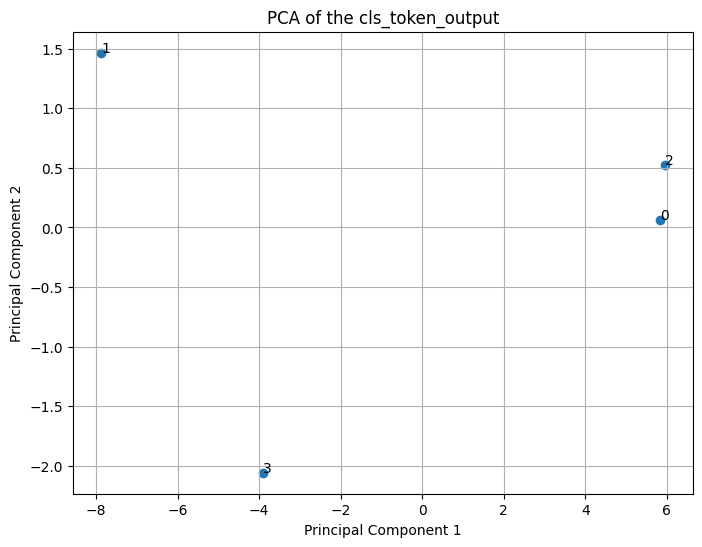

In [57]:
# Plot the PCA results
plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_pca.loc[:, 0], X_pca.loc[:, 1])
for i in range(X_pca.shape[0]):
    cur_record = X_pca.iloc[i,:].copy()
    plt.annotate(cur_record.name, (cur_record[0], cur_record[1]))
    # plt.text(x, y, word, fontsize=12, color='red', ha='center')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of the cls_token_output')
plt.grid(True)
plt.show()

In [58]:
print(predictions)

tensor([1, 0, 1, 0], device='cuda:0')


## Layer weights

In [59]:
# Assuming model is your trained PyTorch model
state_dict = model.state_dict()

# Print all keys in the state_dict to see available weights
for name, param in state_dict.items():
    print(f"Layer: {name}, Size: {param.size()}")


Layer: embedding.weight, Size: torch.Size([28996, 64])
Layer: pos_encoding.pe, Size: torch.Size([1, 512, 64])
Layer: transformer_blocks.0.ln1.weight, Size: torch.Size([64])
Layer: transformer_blocks.0.ln1.bias, Size: torch.Size([64])
Layer: transformer_blocks.0.ln2.weight, Size: torch.Size([64])
Layer: transformer_blocks.0.ln2.bias, Size: torch.Size([64])
Layer: transformer_blocks.0.mha.key.weight, Size: torch.Size([64, 64])
Layer: transformer_blocks.0.mha.key.bias, Size: torch.Size([64])
Layer: transformer_blocks.0.mha.query.weight, Size: torch.Size([64, 64])
Layer: transformer_blocks.0.mha.query.bias, Size: torch.Size([64])
Layer: transformer_blocks.0.mha.value.weight, Size: torch.Size([64, 64])
Layer: transformer_blocks.0.mha.value.bias, Size: torch.Size([64])
Layer: transformer_blocks.0.mha.fc.weight, Size: torch.Size([64, 64])
Layer: transformer_blocks.0.mha.fc.bias, Size: torch.Size([64])
Layer: transformer_blocks.0.ann.0.weight, Size: torch.Size([256, 64])
Layer: transformer_blo

In [60]:
# Example: Accessing weights of a specific layer
layer_name = 'transformer_blocks.0.mha.query.weight'  # Change this to the name of your layer
layer_weights = state_dict[layer_name]

print(f"Weights of {layer_name}:")
print(layer_weights)
print(f'Dim: {layer_weights.shape}')

Weights of transformer_blocks.0.mha.query.weight:
tensor([[ 0.0675,  0.2736, -0.1257,  ...,  0.1431, -0.1102, -0.1213],
        [-0.0348,  0.0553,  0.0936,  ...,  0.0701, -0.1781, -0.0402],
        [-0.2058,  0.0318, -0.1337,  ..., -0.0925, -0.0980,  0.1913],
        ...,
        [-0.0397, -0.0713,  0.0774,  ...,  0.0815,  0.0693,  0.0677],
        [-0.0799,  0.0814,  0.0089,  ...,  0.0890,  0.1097,  0.0802],
        [ 0.0560, -0.0205,  0.1201,  ..., -0.1045,  0.1719,  0.1842]],
       device='cuda:0')
Dim: torch.Size([64, 64])


## Embeddings Layer

In [61]:
layer_name = 'embedding.weight'  # Change this to the name of your layer
layer_weights = state_dict[layer_name]

print(f"Weights of {layer_name}:")
print(layer_weights)
print(f'Dim: {layer_weights.shape}')

Weights of embedding.weight:
tensor([[-1.1920e+00, -1.3478e-03, -1.8566e-01,  ..., -1.1614e+00,
          7.4247e-01,  6.5829e-01],
        [ 1.4371e-01, -1.8632e-01,  1.8430e+00,  ...,  1.4463e-01,
         -7.9386e-02, -1.4493e+00],
        [ 5.5604e-01,  3.3224e-01, -3.1469e-01,  ..., -1.0777e+00,
         -4.7702e-01,  5.1749e-01],
        ...,
        [-6.7391e-01, -7.9383e-01, -3.5490e-01,  ...,  1.5537e+00,
          5.4760e-01, -5.2528e-01],
        [ 1.3108e-01,  8.4052e-02, -6.8896e-01,  ..., -5.3174e-02,
         -1.3378e+00, -3.3551e-01],
        [-1.8970e-01,  9.8277e-01,  2.4177e-01,  ...,  6.9278e-01,
         -7.8067e-02,  8.1229e-02]], device='cuda:0')
Dim: torch.Size([28996, 64])


In [62]:
len(tokenizer.vocab.keys())

28996

In [63]:
tokenizer.vocab

{'##cea': 20287,
 '##rinkled': 24277,
 'days': 1552,
 '##vid': 18312,
 'Wharton': 27256,
 'clarinet': 13866,
 'mon': 19863,
 'Kendra': 14328,
 '##raiser': 27014,
 'ï': 261,
 'Emily': 5590,
 'considerations': 19069,
 'overseas': 7474,
 'Broncos': 14722,
 'amidst': 20746,
 'seat': 1946,
 'zur': 23199,
 'Tribal': 24252,
 '##gger': 9146,
 'wired': 26473,
 'damages': 12947,
 '##bery': 19941,
 'demons': 8568,
 'propose': 17794,
 'former': 1393,
 'Worker': 26455,
 '##teacher': 27889,
 'females': 3032,
 '##Leod': 18763,
 '##unda': 22902,
 'maintains': 9032,
 '##field': 2427,
 '##CC': 12096,
 'ultimate': 10010,
 'stands': 4061,
 'crimes': 6969,
 'coastal': 5869,
 'ʲ': 377,
 'Parish': 6648,
 '##ccelerator': 26154,
 'Archer': 12244,
 'ammunition': 9448,
 'Rail': 8654,
 'cutting': 5910,
 'Cambodian': 27463,
 'Americas': 11198,
 'Fan': 16061,
 'Gibson': 9096,
 'defining': 13682,
 'rigid': 12135,
 '##cripts': 20506,
 'bumper': 26035,
 '##rap': 14543,
 'newspaper': 3054,
 '##matic': 10734,
 '##tania'

## Create word cloud

### PCA of the word embeddings

In [64]:
embeddings_output = layer_weights.to('cpu').numpy()
scaler = StandardScaler()
X_scaled = scaler.fit_transform(embeddings_output)

# Apply PCA
pca = PCA(n_components=2)  # Reduce to 2 dimensions for visualization
X_pca = pca.fit_transform(X_scaled)
X_pca = pd.DataFrame(X_pca,index=tokenizer.vocab.keys())

### Shortlist the words to plot PCA output

#### Create word cloud to find the words

In [65]:
# Combine all the tokens of train to create input to word cloud
train_ids = tokenized_datasets['train']['input_ids']
combined_text = ''
# for id in range(len(train_ids)):
for id in range(1000):
  cur_train_record = (','.join(tokenizer.convert_ids_to_tokens(train_ids[id])) + ',').replace('[', '').replace(']', '') # here we are converting the word index back to word for all the data in train
  combined_text += cur_train_record
combined_text

"CLS,hide,new,secret,##ions,from,the,parental,units,SEP,CLS,contains,no,wit,,,only,labor,##ed,gag,##s,SEP,CLS,that,loves,its,characters,and,communicate,##s,something,rather,beautiful,about,human,nature,SEP,CLS,remains,utterly,satisfied,to,remain,the,same,throughout,SEP,CLS,on,the,worst,revenge,-,of,-,the,-,ne,##rds,c,##lich,##és,the,filmmakers,could,d,##red,##ge,up,SEP,CLS,that,',s,far,too,tragic,to,merit,such,superficial,treatment,SEP,CLS,demonstrates,that,the,director,of,such,ho,##lly,##wood,block,##buster,##s,as,pat,##riot,games,can,still,turn,out,a,small,,,personal,film,with,an,emotional,wall,##op,.,SEP,CLS,of,sa,##uc,##y,SEP,CLS,a,depressed,fifteen,-,year,-,old,',s,su,##icidal,poetry,SEP,CLS,are,more,deeply,thought,through,than,in,most,`,right,-,thinking,',films,SEP,CLS,goes,to,absurd,lengths,SEP,CLS,for,those,movie,##go,##ers,who,complain,that,`,they,do,n,',t,make,movies,like,they,used,to,anymore,SEP,CLS,the,part,where,nothing,',s,happening,,,SEP,CLS,saw,how,bad,this,movie,was,SE

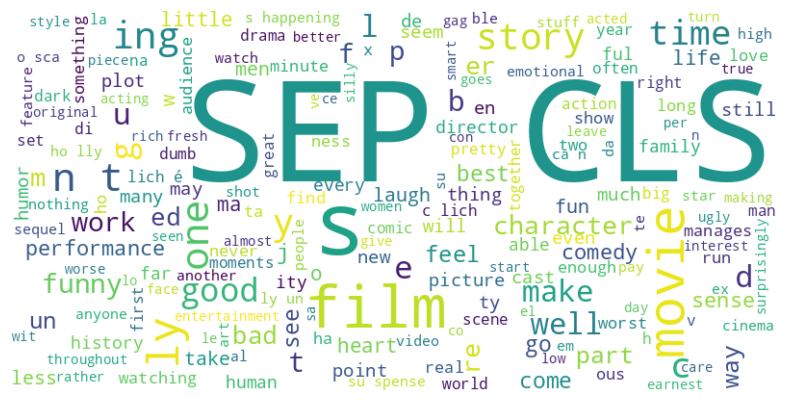

In [66]:
# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white',max_words=200).generate(combined_text)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Do not show axes for a cleaner look
plt.show()

#### Plot the PCA for required words

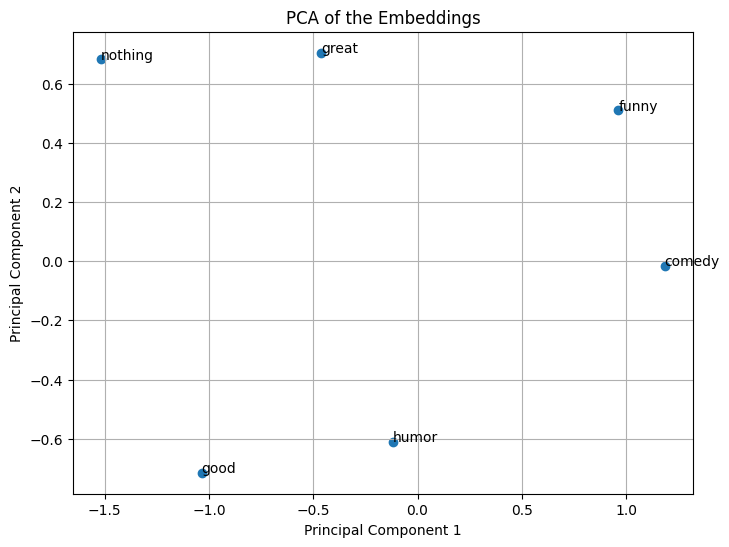

In [68]:
# req_words = ['humor','comedy','funny']
req_words = ['nothing','great','good', 'humor','comedy','funny']
pca_req_words = X_pca.loc[req_words,:].copy()

# Plot the PCA results
plt.figure(figsize=(8, 6))
scatter = plt.scatter(pca_req_words.loc[:, 0], pca_req_words.loc[:, 1])
for i in range(pca_req_words.shape[0]):
    cur_record = pca_req_words.iloc[i,:].copy()
    plt.annotate(cur_record.name, (cur_record[0], cur_record[1]))
    # plt.text(x, y, word, fontsize=12, color='red', ha='center')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of the Embeddings')
plt.grid(True)
plt.show()


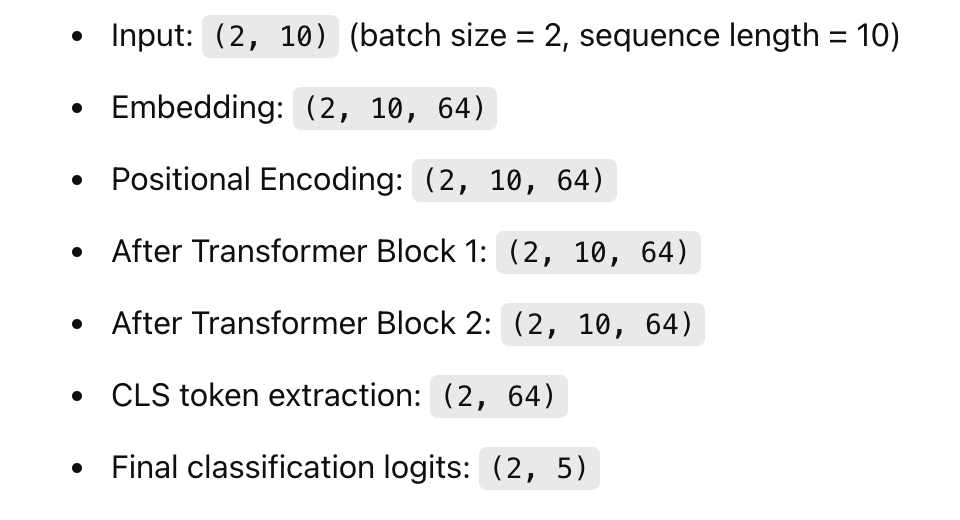

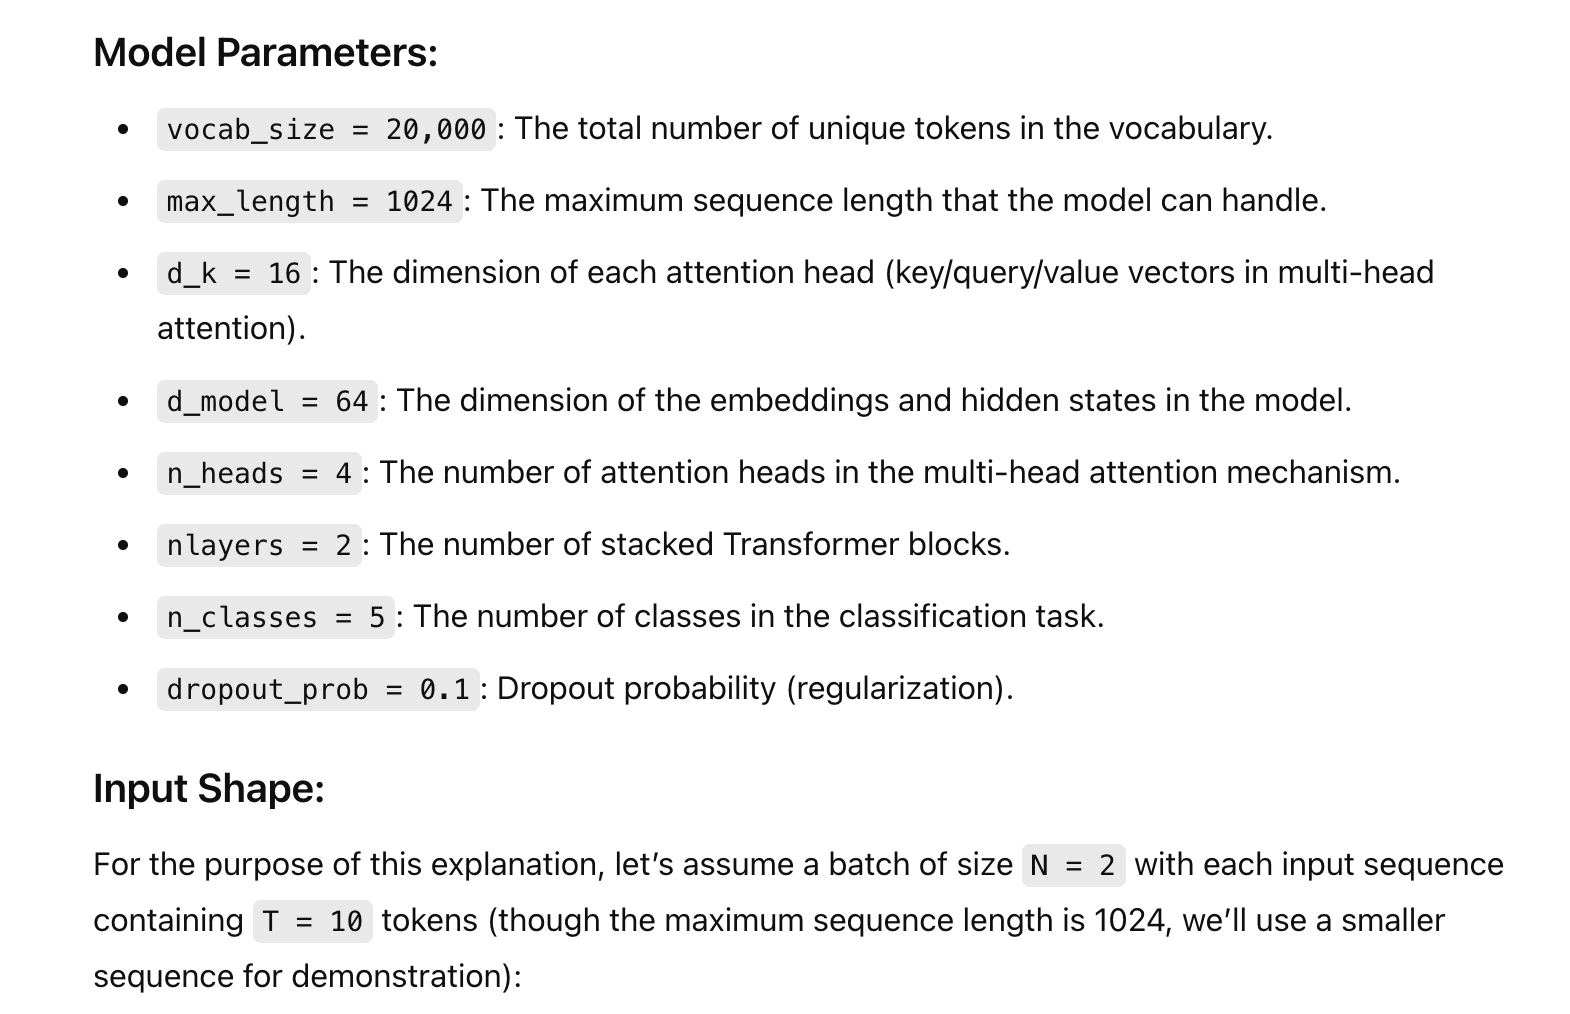

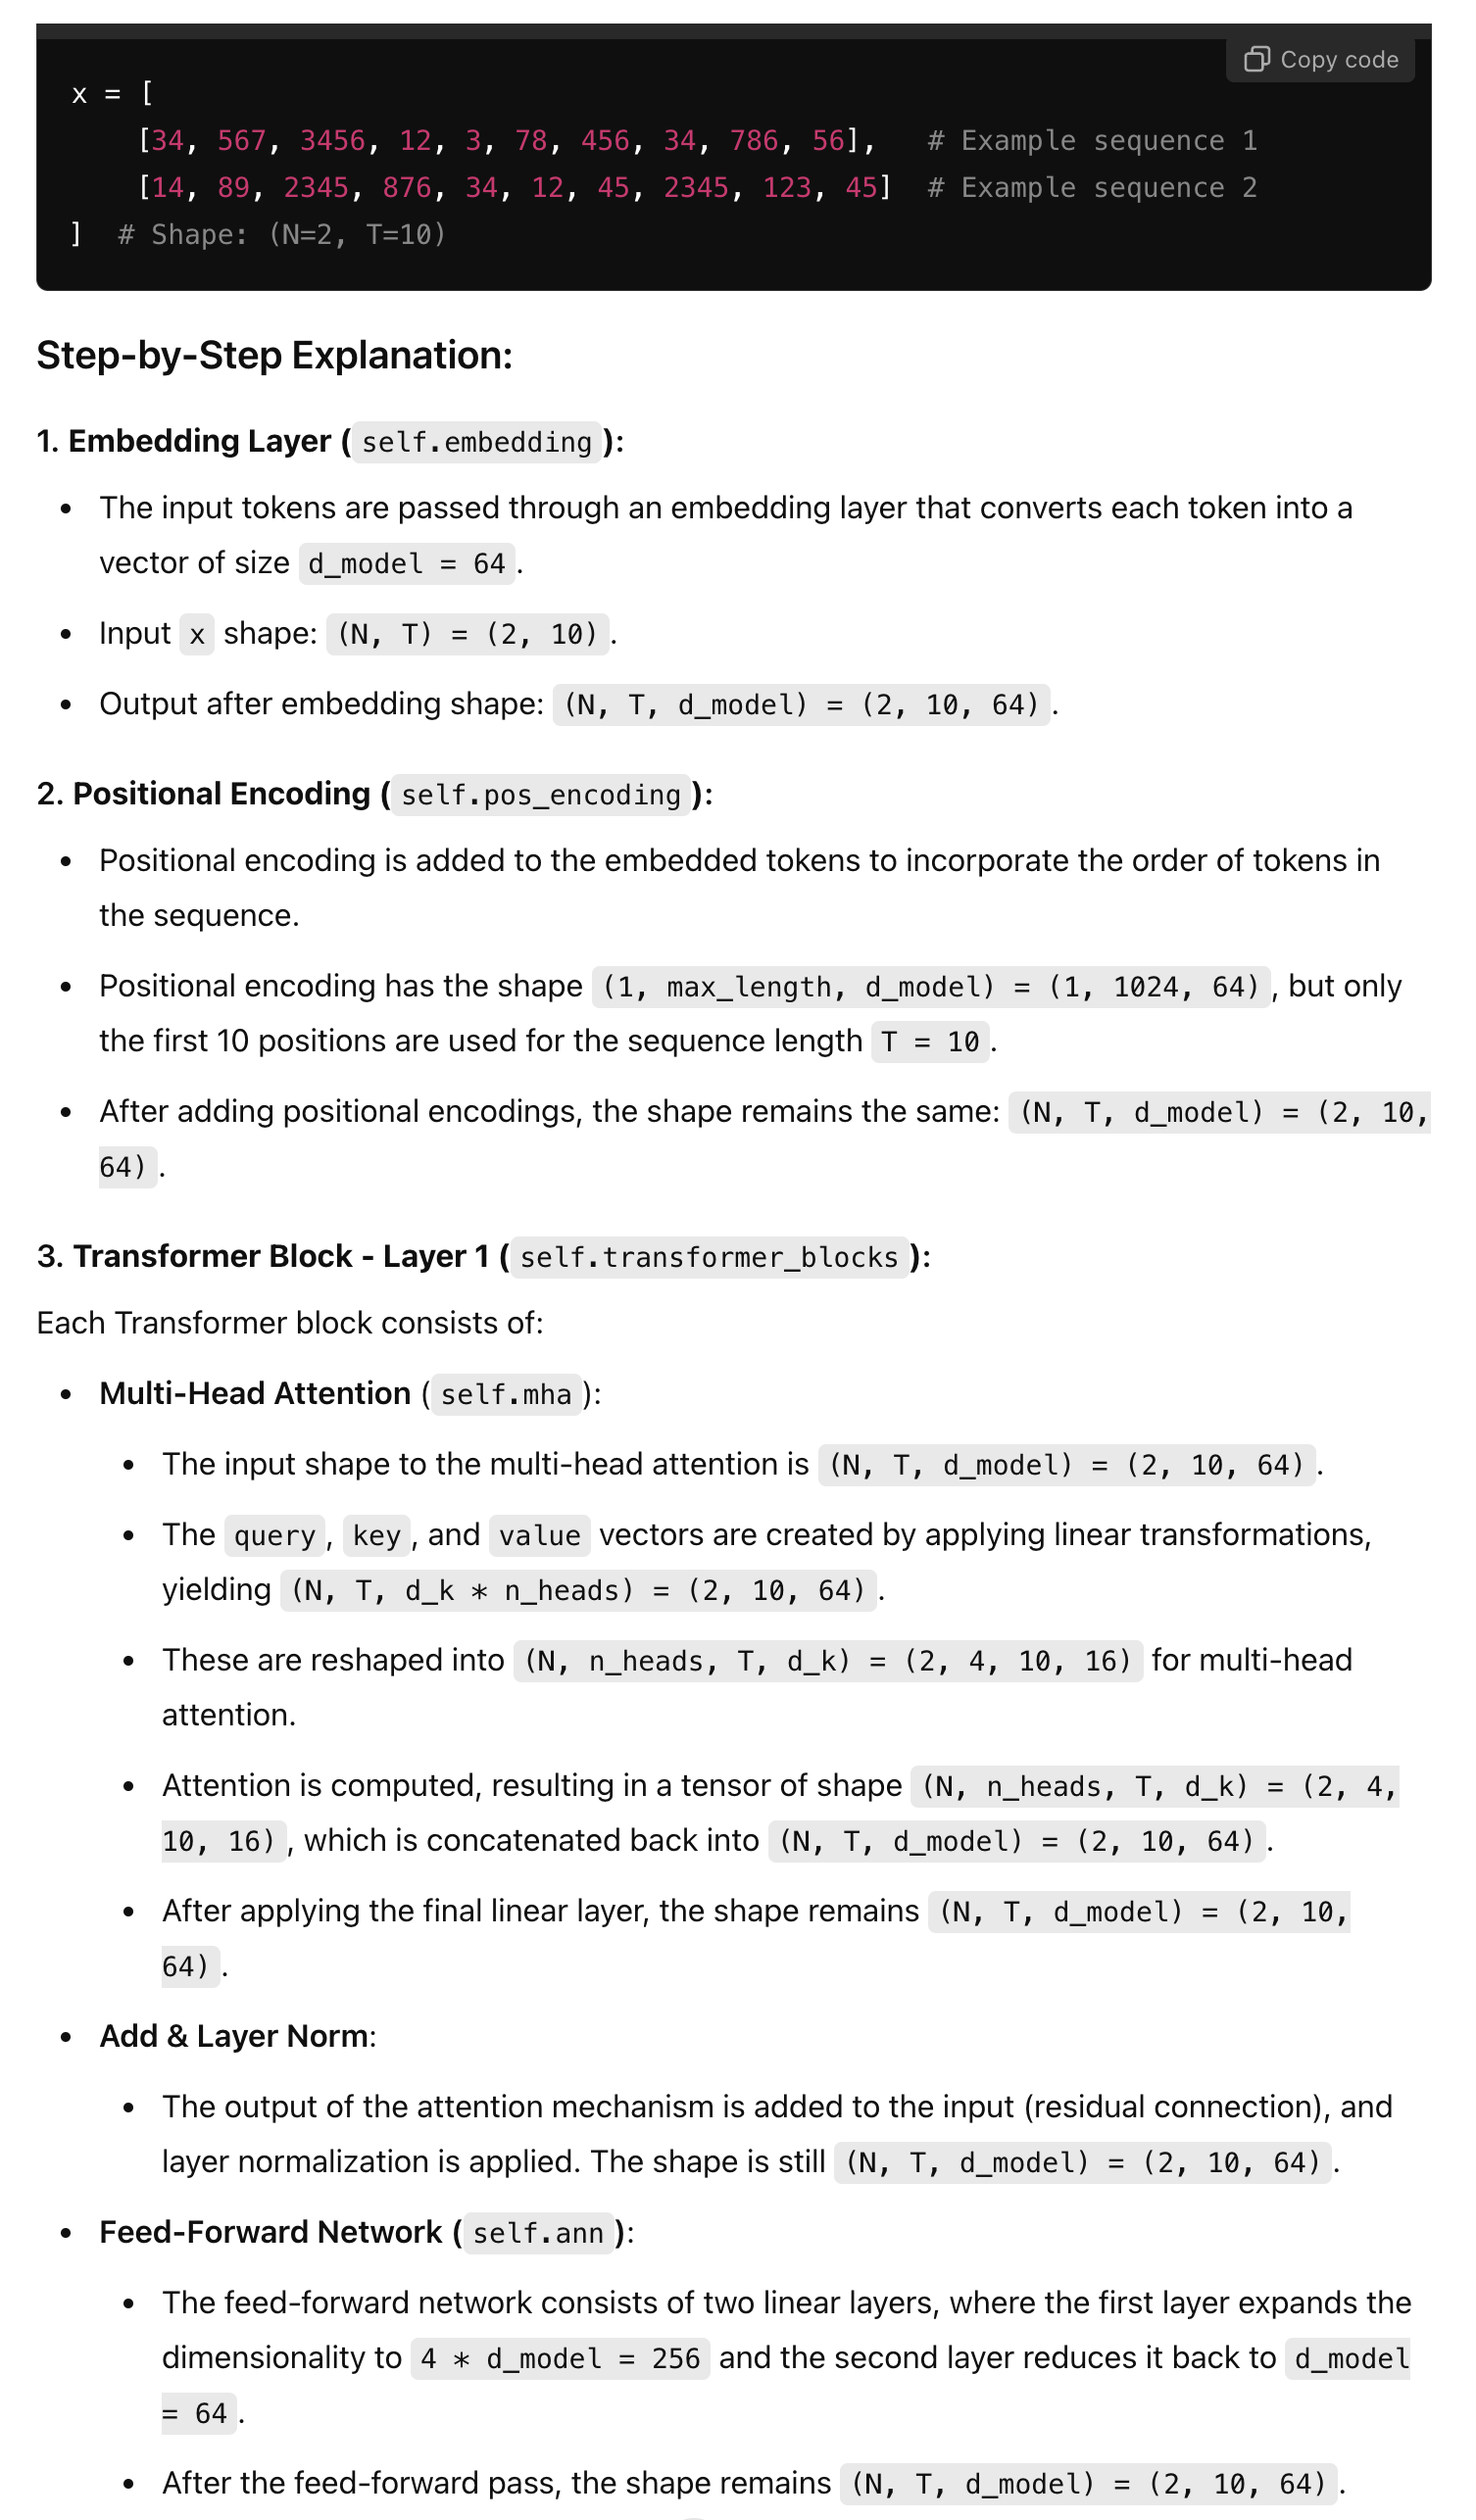

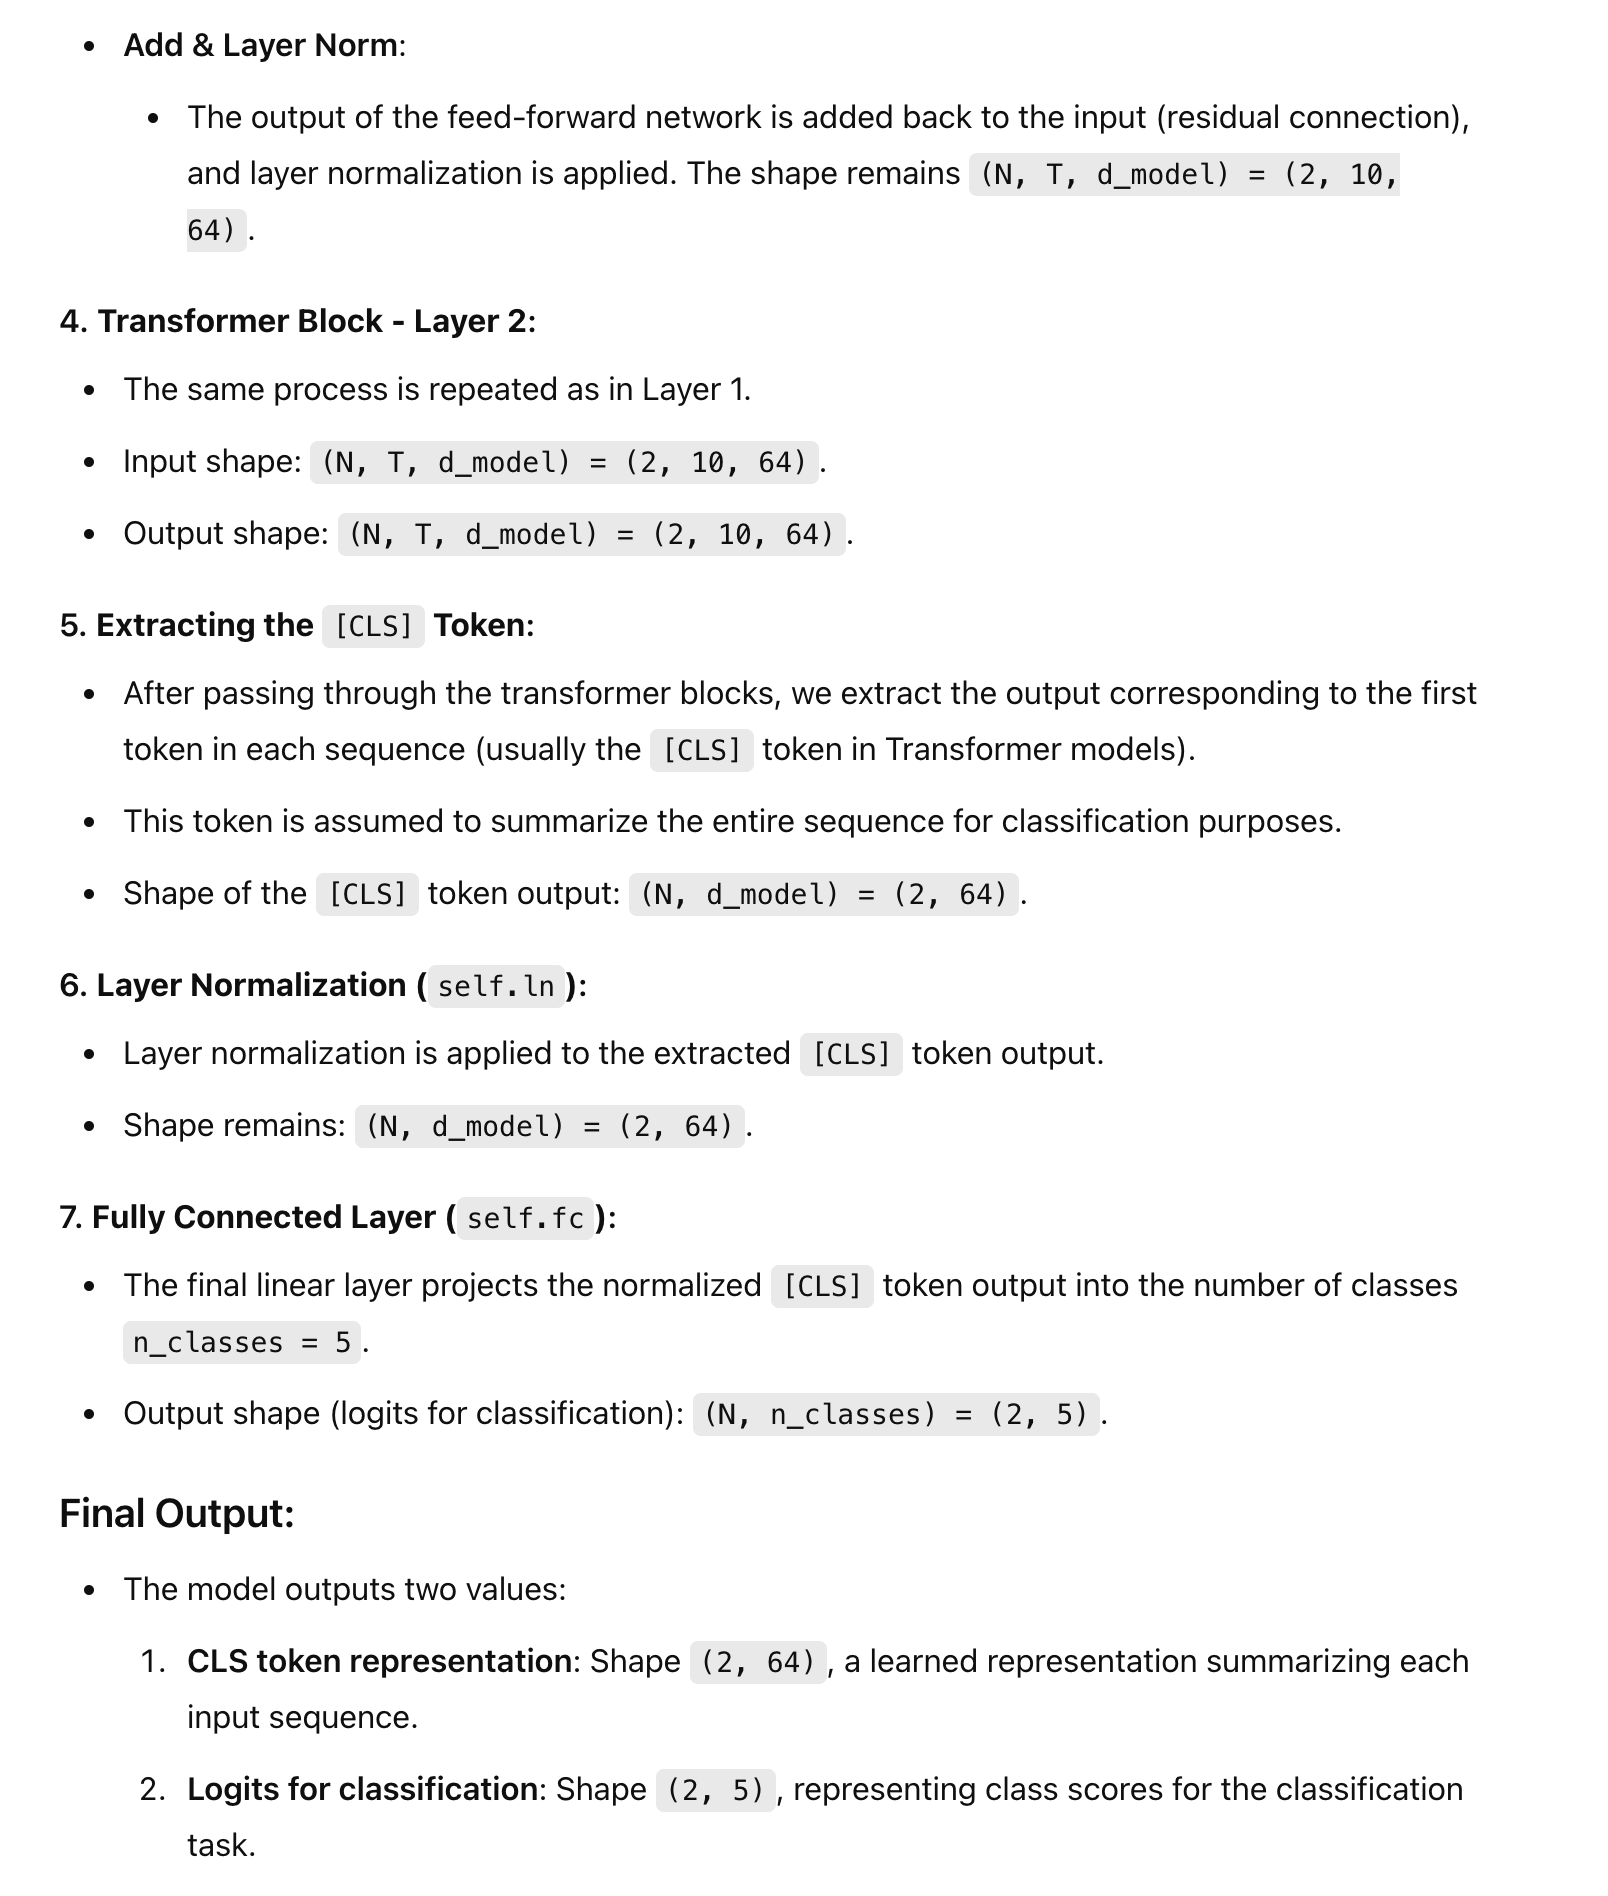

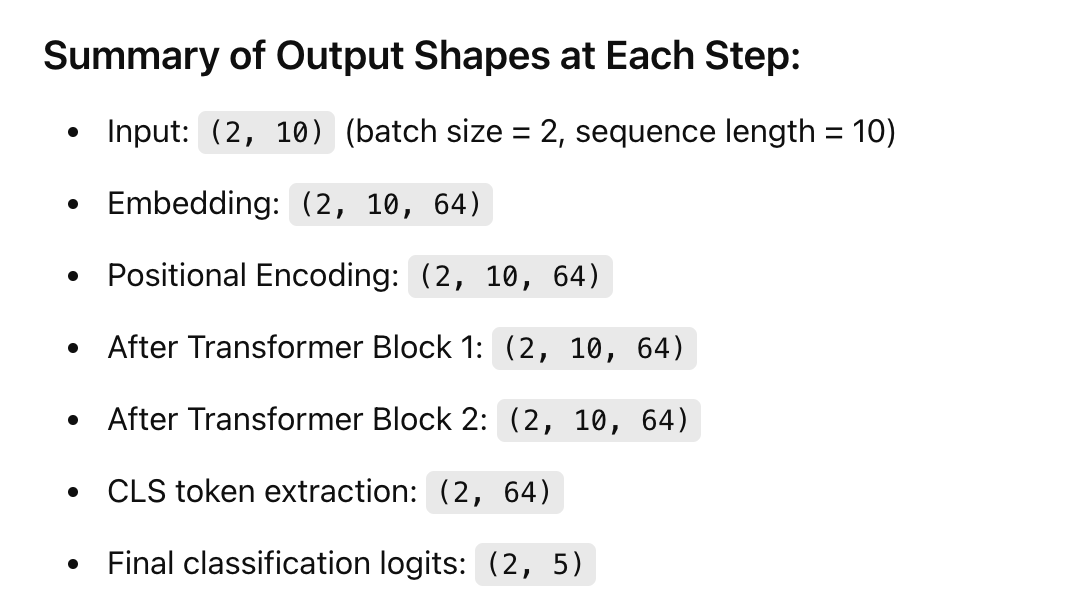

# References

If you are very interested or plan to work closely on Transformers, then following are good resource that explains in simplified manner.

1.[Illustrated-transformer](https://jalammar.github.io/illustrated-transformer/)

2.[Understanding Positional  Encoding](https://erdem.pl/2021/05/understanding-positional-encoding-in-transformers)

3.[Attention Is All You Need](https://arxiv.org/pdf/1706.03762v6.pdf)